In [1]:
#Application of attention model with PTB dataset lead II
#modified by FSB
# * ***** 20211209 *FSB* USING convolution in front of LSTM to extract features and feed it to lstm gives an initial accuracy of 99.50%
import numpy as np
import pandas as pd
#import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
#from tensorflow import keras
from torch import nn
from torch.utils.data import DataLoader , TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchinfo import summary

from datetime import datetime
#from tensorflow.keras import regularizers
#from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn
import itertools
#from tensorflow_addons.optimizers import CyclicalLearningRate
#from tensorflow.keras.layers import LSTM,Bidirectional,Flatten

Using cuda device
TEST


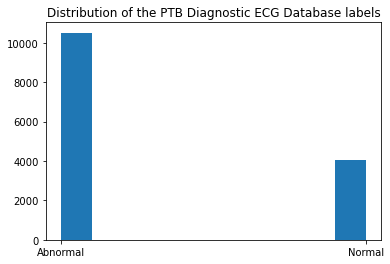

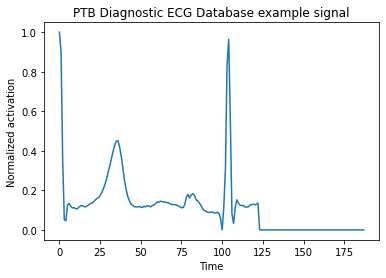

In [103]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


import matplotlib as mpl
#mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
#mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)
ptbdb_abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)
ptbdb_abnormal.values[:,-1]
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
print('TEST')
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")
plt.show()
#plt.plot(ptbdb.iloc[0,:-2])
plt.plot(ptbdb_normal.iloc[0,:])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")
plt.show()

In [60]:

NUM_FEATURES = 1
# For complex phase included, number of features doubles
# NUM_FEATURES = 232*2

SEQ_LENGTH = 187#from shape the number of coloumns

# TODO must not hardcode
# BATCH_SIZE = 32
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 1000

encoder = preprocessing.LabelEncoder()

NUM_CLASSES = -1
X,y= ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values,
print(X.shape)
print(y.shape)
def data2tensor(X, y, encoder):
    """convert rawdata and rawlabel with encoder to pytorch tensor

    Keyword arguments:
    rawdata -- np array of rawdata
    rawlabels -- np array of labels corresponding to rawdata
    encoder -- instance of LabelEncoder used for encoding

    Returns:
    tensor: torch.Tensor of type DoubleTensor with
            dimension [batch size (i.e. number of X instances), NUM_FEATURES, SEQ_LENGTH]
    """
    # labels as digit representation instead of letters
    encoder.fit(y)
    y = encoder.transform(y)
    #print('ANOTHER TEST')
    tensors = []
    labels = []
    for i in range(len(y)):
        #if X[i].shape == (NUM_FEATURES, SEQ_LENGTH):  # skip data with incorrect dimensions TODO: avoid hardcoding
            # r_tensor = torch.tensor(rawdata[i].real, device=device)
            # i_tensor = torch.tensor(rawdata[i].imag, device=device)
            # tensors.append(torch.cat((r_tensor, i_tensor), 0))

            # append the absolute value (TODO should be configurable)

            # ts_fft = sp.fftpack.fft(rawdata[i])
            # ts_psd = np.abs(ts_fft) ** 2
            # tensors.append(torch.tensor(ts_psd, device=device))
        tensors.append(torch.tensor(np.absolute(X[i]), device=device))
        labels.append(y[i])
    #tensors=np.array(tensors)
    #tensors=np.expand_dims(tensors,2)
    return torch.stack(tensors), torch.as_tensor(labels, device=device)

#rawdata, rawlabels = load_dataset(csi_data)
print('ANOTHER TEST')
data, labels = data2tensor(X, y, encoder)
print(data.type)
#data= data.argmax
data=data.cpu().numpy()

#data=np.array(data)
#print(data.shape)
#expanding dimensions to make it 3-D
print('Before')
#data=data.expand_dims(data,1)

data=np.expand_dims(data,1)
print(data.shape)
data= torch.tensor(data)
print(data.shape)


mean = torch.mean(data)
std = torch.std(data)

from torchvision import transforms
normalize = transforms.Normalize(mean, std)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nor_data = normalize(data).to(device)

dataset = TensorDataset(nor_data, labels)
#dataset = TensorDataset(data, labels)
#dataset = dataset.to(device=torch.device("cuda:0"))
print('ANOTHER TEST')
NUM_CLASSES = len(encoder.classes_)
print(NUM_CLASSES)
# split data into training, validation, and test (todo: make better configurable)
full_size = int(len(dataset))
train_size = int(0.8 * full_size)
val_size = (len(dataset) - train_size)//2
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, full_size - train_size-val_size], generator=torch.Generator().manual_seed(4))

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())


(14552, 187)
(14552,)
ANOTHER TEST
<built-in method type of Tensor object at 0x7f91f7f94050>
Before
(14552, 1, 187)
torch.Size([14552, 1, 187])
ANOTHER TEST
2


In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import sklearn.metrics as metrics


#X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
#X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)
print('AFTER DIVISION')
#print(X_ptbdb_train.shape)

#print(X_ptbdb_val.shape)
print(len(dataloader_val))
print(len(dataloader_test))
print(data.shape)
#print(data.type())
torch.cuda.empty_cache()
#####
class CNN(nn.Module):
    def __init__(self, hidden):
        super(CNN, self).__init__()

        self.hiddenLast=hidden
        self.hidden1=187#64
        self.hidden2=64#128
        self.hidden3=64#128
        self.hidden4=64
        self.hidden5=64
        self.hidden6=64

        self.kernel_size=2
        
        self.activation=nn.ReLU()

        self.first=True
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.hidden1, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden1),
            self.activation,
            #nn.MaxPool1d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden1, out_channels=self.hidden2, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden2),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden2, out_channels=self.hidden3, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden3),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden3, out_channels=self.hidden4, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden4),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden4, out_channels=self.hidden5, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden5),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden5, out_channels=self.hidden6, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden6),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.convLast = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden4, out_channels=self.hiddenLast, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hiddenLast),
            self.activation,
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2)
        )


    def forward(self, x):
        #print('SHAPE AFTER',x.shape)
        x = self.conv1(x)
        #print('SHAPE AFTER',x.shape)
        #x = self.conv2(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = self.conv5(x)
        #x = self.conv6(x)
        x = self.convLast(x)
        if self.first:
            #print(x.size())
            self.first=False
        return x

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.cnn_output = 128
        # Depends on number of CNN layers, how often Max Pooling is used etc.
        self.seq_length_after_cnn =10#128#48#53#248
        #1998
        self.hidden_lstm = 128

        self.cnn = CNN(hidden=self.cnn_output)
        #self.cnn = CNN(hidden=self.cnn_output)
        #self.cnn = CNN(hidden=self.cnn_output)
        self.lstm = nn.LSTM(input_size=self.cnn_output, hidden_size=self.hidden_lstm, batch_first=True, num_layers=3)
      
        self.fc = nn.Linear(in_features=self.hidden_lstm*self.seq_length_after_cnn, out_features=2)


    def forward(self, x):
        # 3d: batch size, features (1), seq length (4000)
        ##print('SHAPE',x.shape)
        #x = x.permute(0, 2, 1)
        x = self.cnn(x)
        

        ##print('AFTER CNN',x.shape)
        # 3d: batch size, features (self.hidden_cnn), seq length after cnn
        x = x.permute(0, 2, 1)
        ##print('AFTER PE')
        # 3d: batch size, seq length, features
        x, (h_n, c_n) = self.lstm(x)
        #x, (h_n, c_n) = self.lstm(x)
        ##print('AFTER LSTM',x.shape)
        # 3d: batch size, seq length, features
        x = x.reshape(-1, self.hidden_lstm*self.seq_length_after_cnn)
        ##print('AFTER RESHAPE')
        # 2d: batch size, (features*seq length)
        x = self.fc(x)
        return x

    

AFTER DIVISION
23
23
torch.Size([14552, 1, 187])


In [137]:
model = CNN_LSTM().to(device)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = loss_fn = nn.CrossEntropyLoss(weight=sc, reduction='mean', label_smoothing=0.08)#nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)



In [138]:
val_losses = []
train_losses = []
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    log_step = 10

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % log_step == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    train_losses.append(train_loss)
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)


def validation_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    val_losses.append(validation_loss)
    correct /= size
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Validation', validation_loss, epoch)
    print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {validation_loss:>8f}")
    return (correct, validation_loss)

In [145]:
from datetime import datetime

%xmode Verbose

loss_of_best_accuracy = float('inf')
best_accuracy = 0
best_model = None
best_epoch = 0
print(summary(model))
start_time = datetime.now()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer, t+1)
    accuracy, loss = validation_loop(dataloader_val, model, loss_fn, t+1)
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < loss_of_best_accuracy):
        best_accuracy = accuracy
        loss_of_best_accuracy = loss
        best_model = copy.deepcopy(model)
        best_epoch = t+1
        print('Model saved')
end_time = datetime.now()
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")



Exception reporting mode: Verbose
Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─CNN: 1-1                               --
│    └─ReLU: 2-1                         --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  561
│    │    └─BatchNorm1d: 3-2             374
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-4                  24,000
│    │    └─BatchNorm1d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    │    └─MaxPool1d: 3-7               --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-8                  8,256
│    │    └─BatchNorm1d: 3-9             128
│    │    └─ReLU: 3-10                   --
│    │    └─MaxPool1d: 3-11              --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-12                 8,256
│    │    └─BatchNorm1d: 3-13            128
│    │    └─ReLU: 3-14

In [146]:
@torch.no_grad()
def predict(model, loader):
    # initialise empty tensors for predictions and targets
    all_preds = torch.tensor([], device=device, dtype=int)
    all_targets = torch.tensor([], device=device, dtype=int)
    model.eval()
    for batch in loader:
        data, labels = batch
        preds = model(data.float()).argmax(1)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat((all_targets, labels.int()), dim=0)
    model.train()    
    return all_preds, all_targets


In [147]:
with torch.no_grad():
  predictions, targets = predict(best_model, dataloader_test)

/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


0.9979395604395604


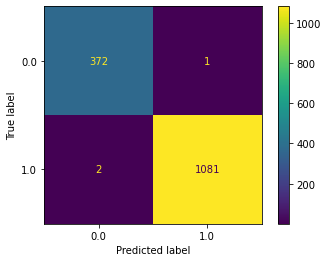

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

print(accuracy_score(predictions.cpu(), targets.cpu()))

cm = confusion_matrix(targets.cpu(), predictions.cpu())
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot()

In [151]:
print(summary(model))


Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─CNN: 1-1                               --
│    └─ReLU: 2-1                         --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  561
│    │    └─BatchNorm1d: 3-2             374
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-4                  24,000
│    │    └─BatchNorm1d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    │    └─MaxPool1d: 3-7               --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-8                  8,256
│    │    └─BatchNorm1d: 3-9             128
│    │    └─ReLU: 3-10                   --
│    │    └─MaxPool1d: 3-11              --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-12                 8,256
│    │    └─BatchNorm1d: 3-13            128
│    │    └─ReLU: 3-14                   --
│    │    └─